- LSTM forecast pipeline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


C:\Users\rafae\AppData\Local\Temp\ipykernel_10684\1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


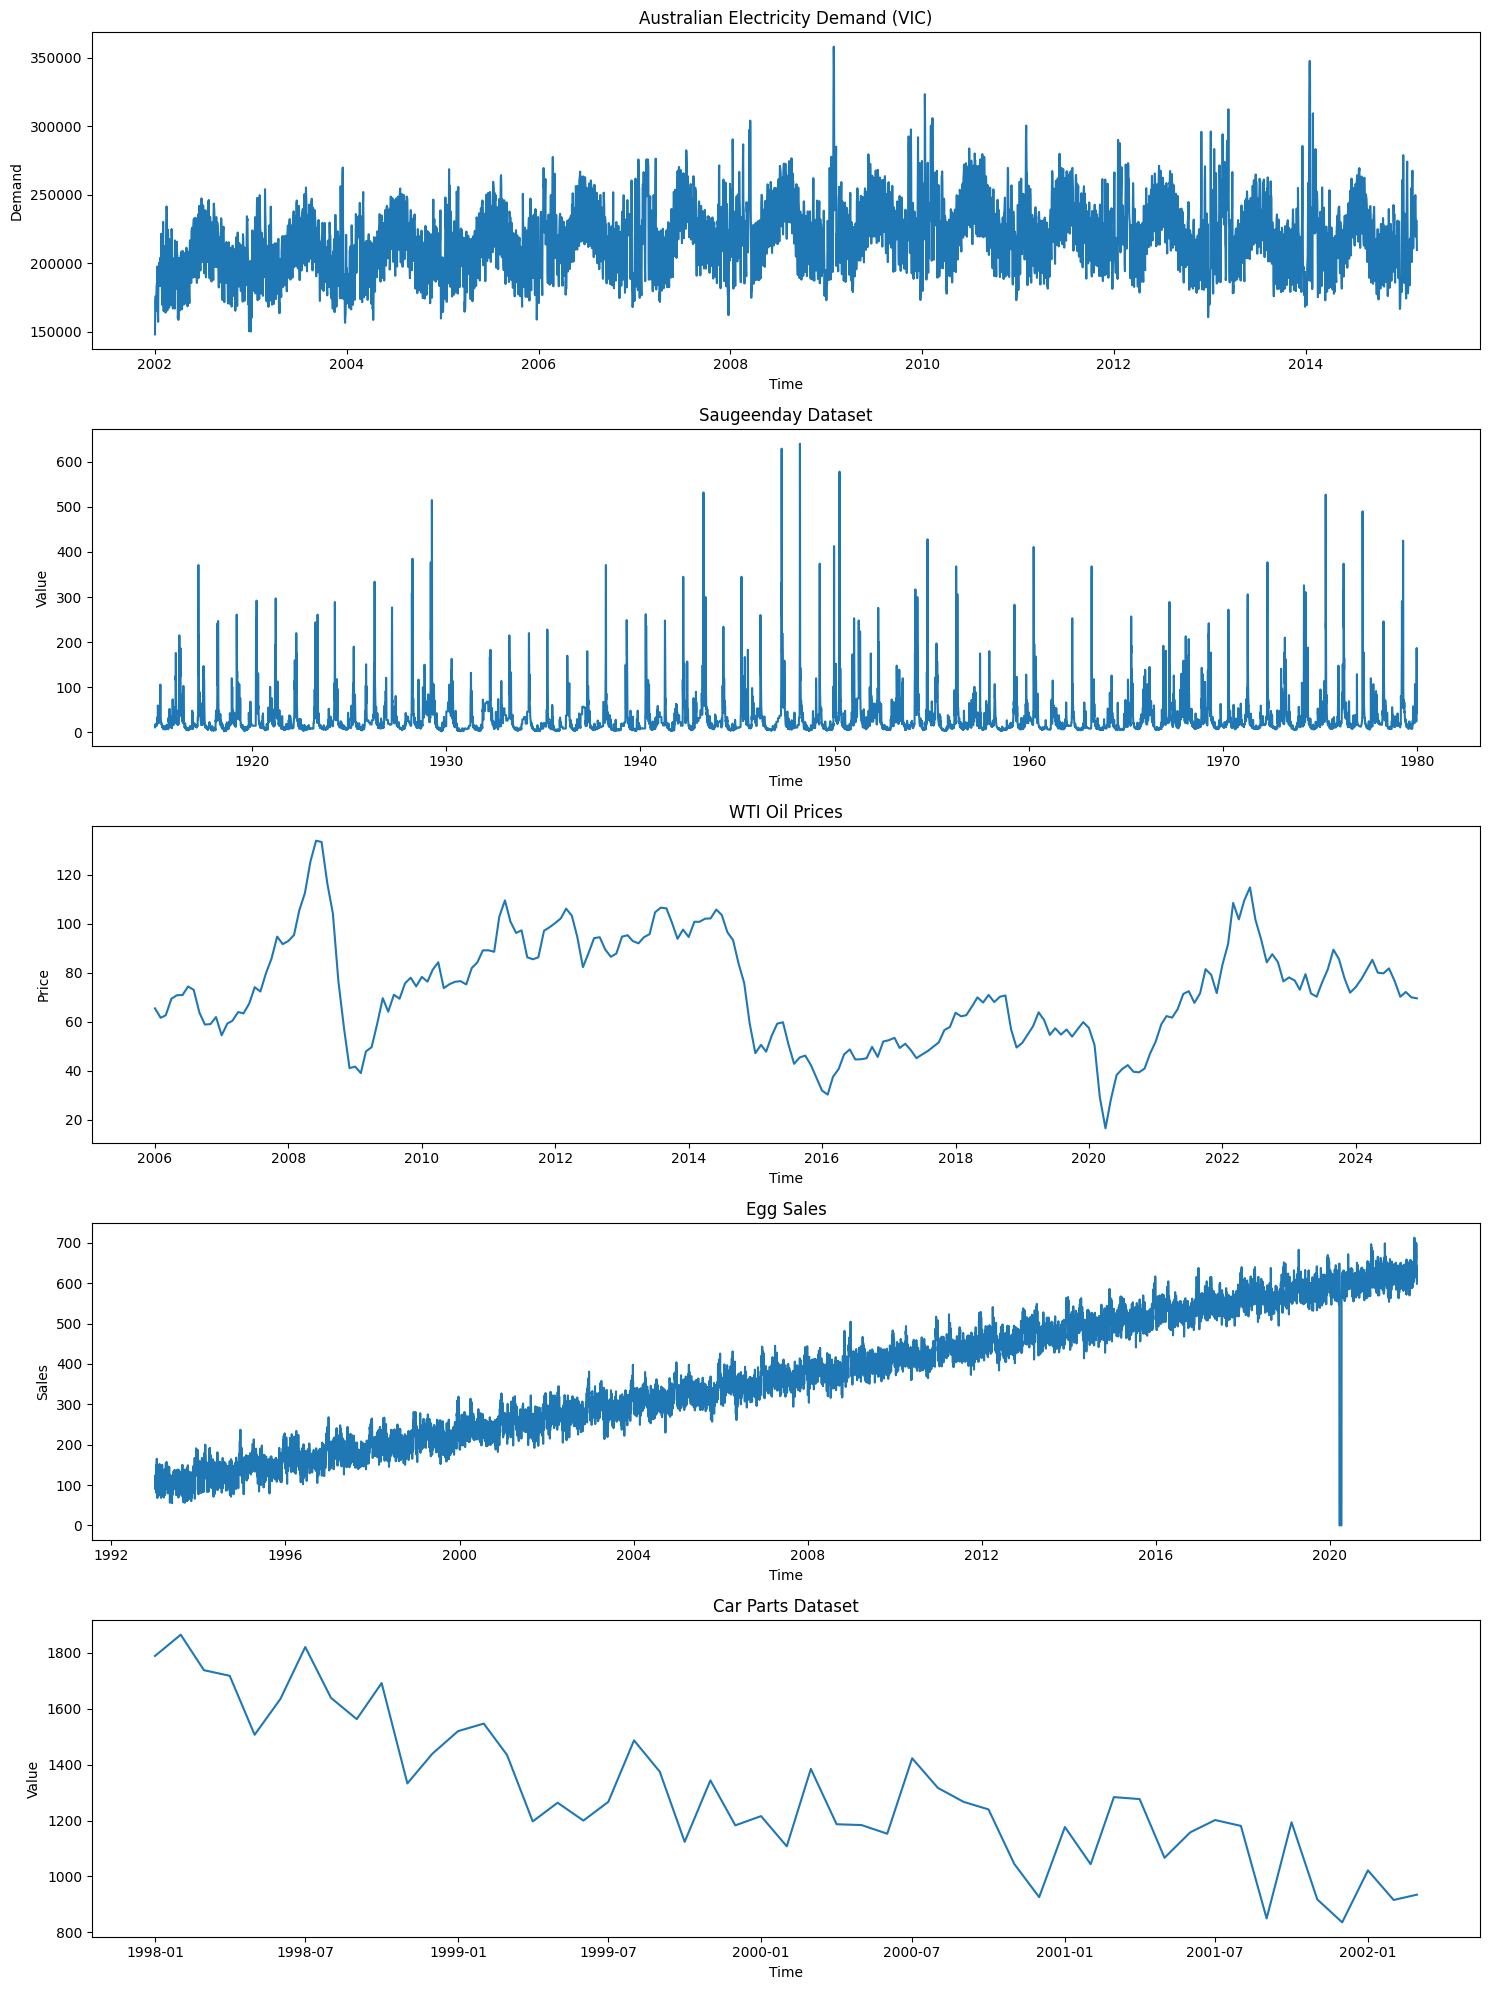

In [12]:
%run datagetter.ipynb
%run basic_functions.ipynb

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def calc_forecast_metrics(y_true, y_pred):
    """Return MAE, MAPE, RMSE in a dictionary for model evaluation."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse}

def lstm_forecast(
    train_df, test_df,
    lookback=14,
    lstm_units=64,
    dropout=0.2,
    epochs=20,
    batch_size=32,
    figsize=(14, 6),
    crossval=False,
    cv_splits=3,
    cv_test_size=0.1,  # Fraction of data per CV test split
    cv_verbose=True
):
    """
    Forecast with LSTM, plot, print metrics, and (optionally) run rolling-origin CV.
    Returns: model, forecast_df, metrics, (cv_results, cv_metrics) if crossval=True
    """
    # ----  Forecast ----
    data = pd.concat([train_df, test_df], ignore_index=True)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data['y'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled)):
        X.append(scaled[i-lookback:i, 0])
        y.append(scaled[i, 0])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split_idx = len(train_df) - lookback
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test, y_test), verbose=0)
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    test_dates = test_df['ds'].iloc[:len(y_test_true)]

    plt.figure(figsize=figsize)
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
    plt.plot(test_df['ds'].iloc[:len(y_test_true)], y_test_true, label='Test Data', color='green')
    plt.plot(test_df['ds'].iloc[:len(y_pred)], y_pred, label='LSTM Forecast', color='darkorange')
    plt.axvline(test_df['ds'].iloc[0], color='tab:red', linestyle='--', label='Train/Test Split')
    plt.title('LSTM Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- METRICS ----
    metrics = calc_forecast_metrics(y_test_true, y_pred)
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print(f"RMSE: {metrics['RMSE']:.2f}")

    # ---- RESULTS ----
    results = {
        'model': model,
        'forecast': pd.DataFrame({'ds': test_dates, 'y_true': y_test_true, 'y_pred': y_pred}),
        'metrics': metrics
    }

    # ---- Cross-validation ----
    if crossval:
        if cv_verbose:
            print("\nRolling-origin cross-validation:")

        all_cv_metrics = []
        cv_forecasts = []

        # Use the entire (train+test) dataset for splits
        full_df = pd.concat([train_df, test_df], ignore_index=True)
        n = len(full_df)
        lookback_points = lookback
        split_size = int(n * cv_test_size)
        for i in range(cv_splits):
            train_end = n - (cv_splits - i) * split_size
            test_start = train_end
            test_end = min(test_start + split_size, n)
            if test_end - test_start <= lookback_points or train_end <= lookback_points:
                continue  # Not enough data to split

            train_cv = full_df.iloc[:train_end]
            test_cv = full_df.iloc[test_start:test_end]

            # Prepare scaled data for this split
            data_cv = pd.concat([train_cv, test_cv], ignore_index=True)
            scaler_cv = MinMaxScaler()
            scaled_cv = scaler_cv.fit_transform(data_cv['y'].values.reshape(-1, 1))

            X_cv, y_cv = [], []
            for j in range(lookback, len(scaled_cv)):
                X_cv.append(scaled_cv[j-lookback:j, 0])
                y_cv.append(scaled_cv[j, 0])
            X_cv = np.array(X_cv)
            y_cv = np.array(y_cv)
            X_cv = X_cv.reshape((X_cv.shape[0], X_cv.shape[1], 1))

            split_cv_idx = len(train_cv) - lookback
            X_train_cv, X_test_cv = X_cv[:split_cv_idx], X_cv[split_cv_idx:]
            y_train_cv, y_test_cv = y_cv[:split_cv_idx], y_cv[split_cv_idx:]

            model_cv = Sequential([
                LSTM(lstm_units, input_shape=(lookback, 1)),
                Dropout(dropout),
                Dense(1)
            ])
            model_cv.compile(loss='mse', optimizer='adam')
            model_cv.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size,
                         validation_data=(X_test_cv, y_test_cv), verbose=0)
            y_pred_cv_scaled = model_cv.predict(X_test_cv)
            y_pred_cv = scaler_cv.inverse_transform(y_pred_cv_scaled).flatten()
            y_test_cv_true = scaler_cv.inverse_transform(y_test_cv.reshape(-1, 1)).flatten()
            test_cv_dates = test_cv['ds'].iloc[:len(y_test_cv_true)]
            cv_metrics = calc_forecast_metrics(y_test_cv_true, y_pred_cv)
            all_cv_metrics.append(cv_metrics)
            cv_forecasts.append(
                pd.DataFrame({'ds': test_cv_dates, 'y_true': y_test_cv_true, 'y_pred': y_pred_cv})
            )
            if cv_verbose:
                print(f"Split {i+1}: MAE={cv_metrics['MAE']:.2f}  MAPE={cv_metrics['MAPE']:.2f}%  RMSE={cv_metrics['RMSE']:.2f}")

        if all_cv_metrics:
            avg_mae = np.mean([m['MAE'] for m in all_cv_metrics])
            avg_mape = np.mean([m['MAPE'] for m in all_cv_metrics])
            avg_rmse = np.mean([m['RMSE'] for m in all_cv_metrics])
            print(f"\nAverage CV Metrics over {len(all_cv_metrics)} splits:")
            print(f"MAE: {avg_mae:.2f}")
            print(f"MAPE: {avg_mape:.2f}%")
            print(f"RMSE: {avg_rmse:.2f}")
            results['cv_metrics'] = {
                'MAE': avg_mae,
                'MAPE': avg_mape,
                'RMSE': avg_rmse,
                'all_splits': all_cv_metrics
            }
            results['cv_forecasts'] = cv_forecasts

    return results


==== WTI Oil ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


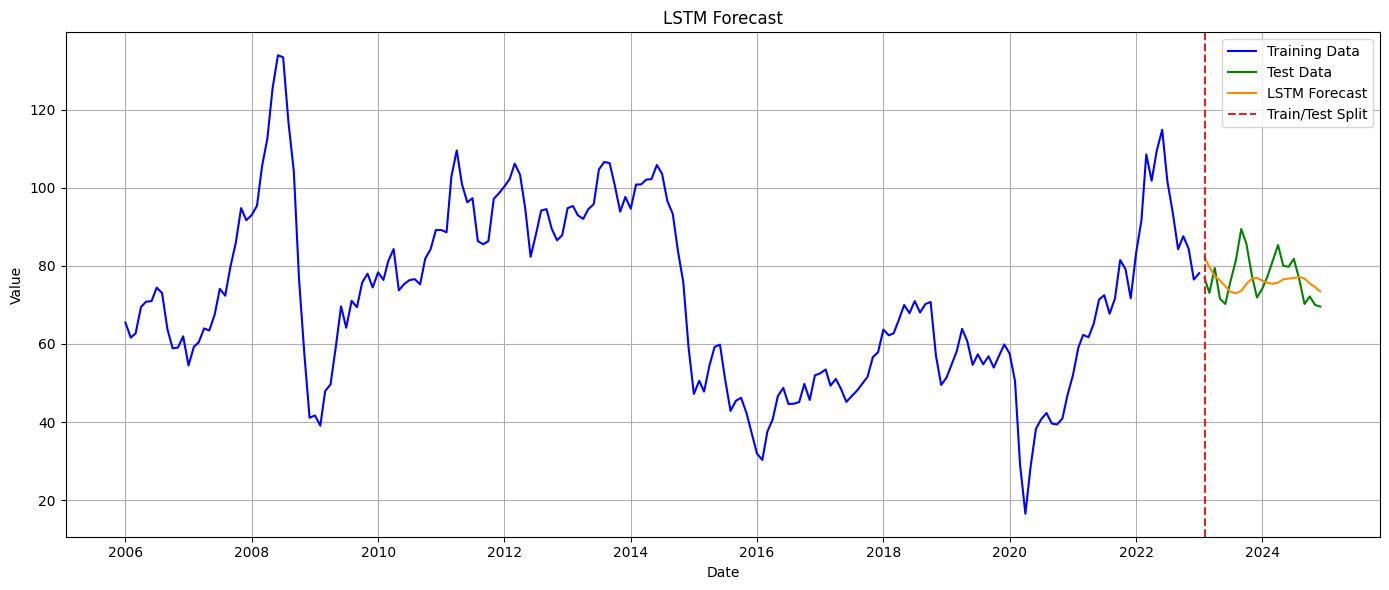

MAE: 5.04
MAPE: 6.43%
RMSE: 6.07

Rolling-origin cross-validation:


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Split 1: MAE=10.35  MAPE=32.79%  RMSE=14.37


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Split 2: MAE=12.60  MAPE=14.10%  RMSE=15.26


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Split 3: MAE=4.99  MAPE=6.36%  RMSE=6.06

Average CV Metrics over 3 splits:
MAE: 9.31
MAPE: 17.75%
RMSE: 11.90
==== Saugeen River ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


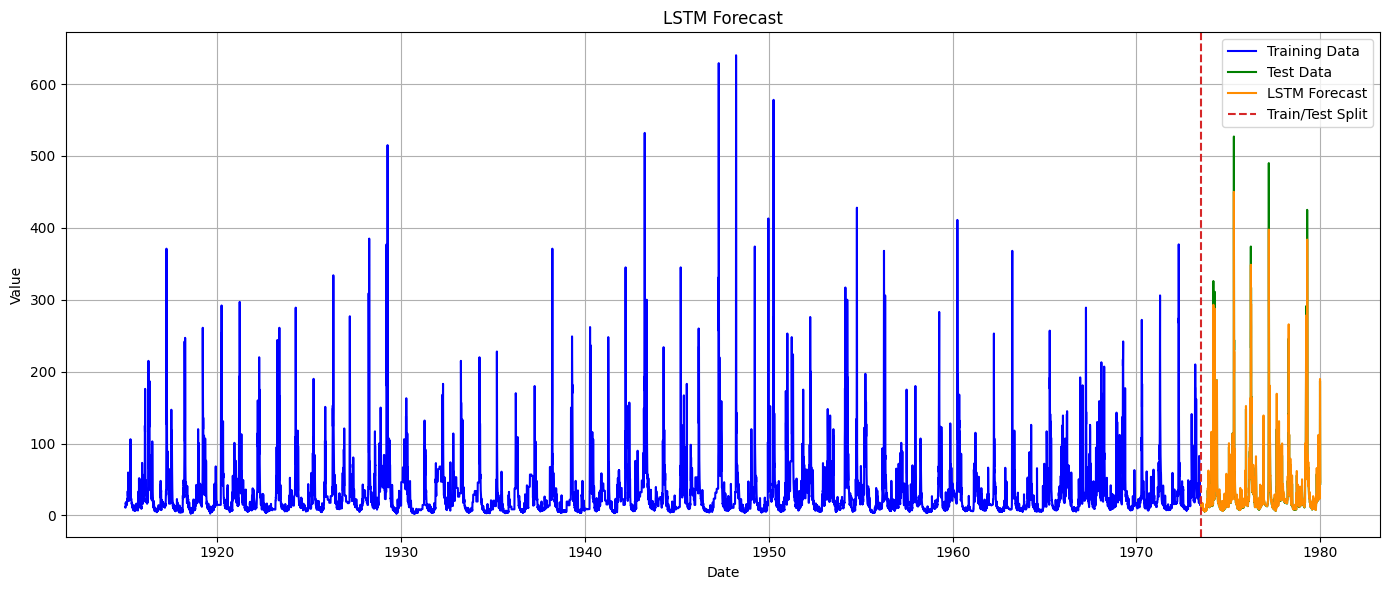

MAE: 4.12
MAPE: 9.83%
RMSE: 12.15

Rolling-origin cross-validation:


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Split 1: MAE=4.26  MAPE=23.60%  RMSE=8.02


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Split 2: MAE=5.75  MAPE=21.88%  RMSE=10.29


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Split 3: MAE=6.09  MAPE=21.88%  RMSE=12.68

Average CV Metrics over 3 splits:
MAE: 5.36
MAPE: 22.45%
RMSE: 10.33
==== Egg Sales ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


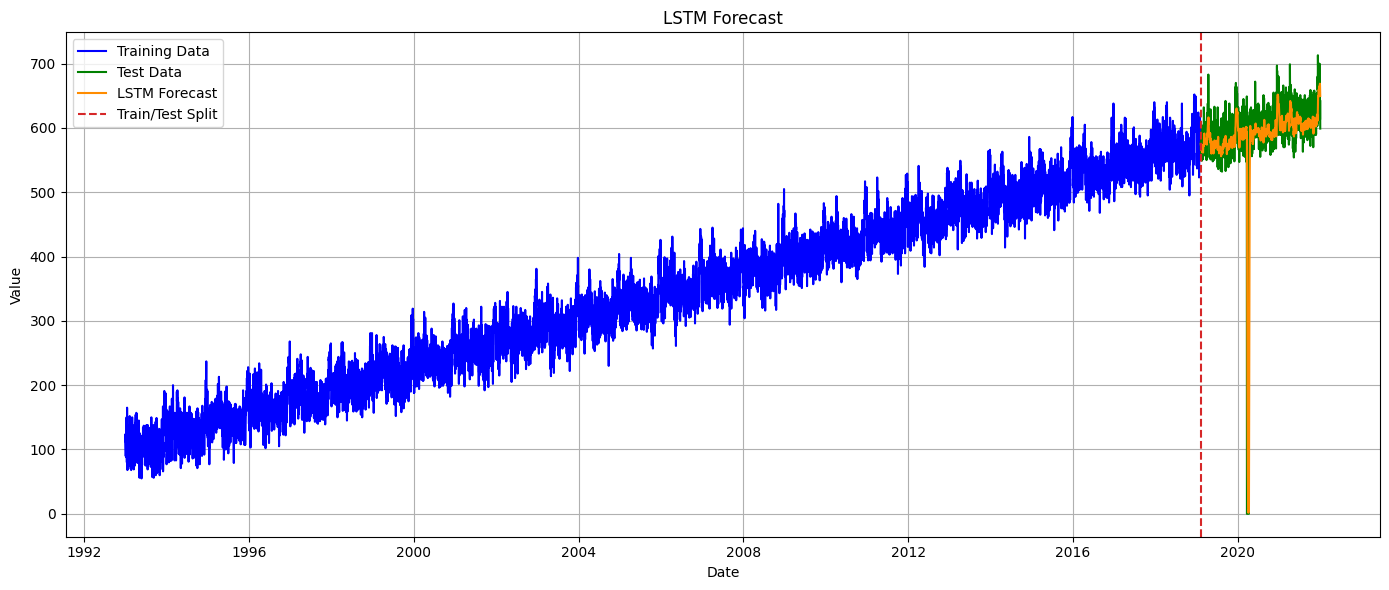

MAE: 24.26
MAPE: 3.62%
RMSE: 49.57

Rolling-origin cross-validation:


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Split 1: MAE=18.60  MAPE=3.72%  RMSE=23.27


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Split 2: MAE=17.72  MAPE=3.19%  RMSE=22.59


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Split 3: MAE=23.28  MAPE=3.45%  RMSE=49.59

Average CV Metrics over 3 splits:
MAE: 19.87
MAPE: 3.45%
RMSE: 31.81
==== Australian Electricity Demand ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


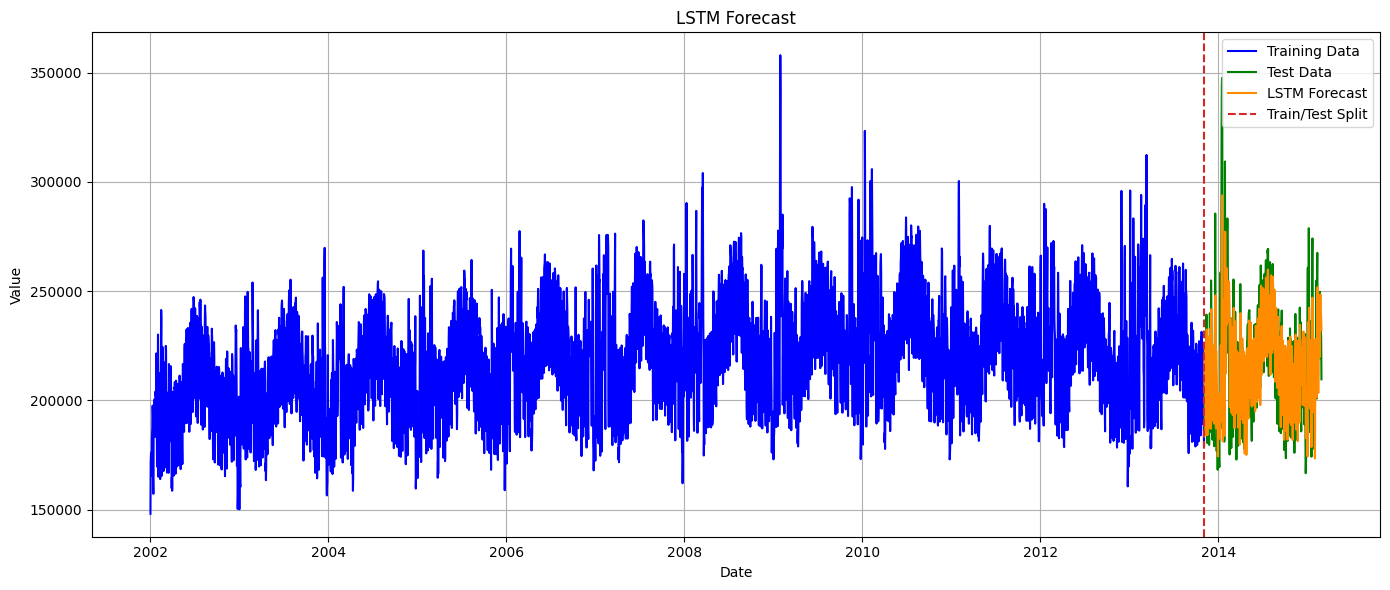

MAE: 11491.77
MAPE: 5.20%
RMSE: 16525.24

Rolling-origin cross-validation:


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Split 1: MAE=10890.59  MAPE=4.77%  RMSE=14310.88


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Split 2: MAE=11748.57  MAPE=5.36%  RMSE=15751.28


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Split 3: MAE=13396.38  MAPE=6.14%  RMSE=17770.26

Average CV Metrics over 3 splits:
MAE: 12011.85
MAPE: 5.42%
RMSE: 15944.14
==== Car Parts ====


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


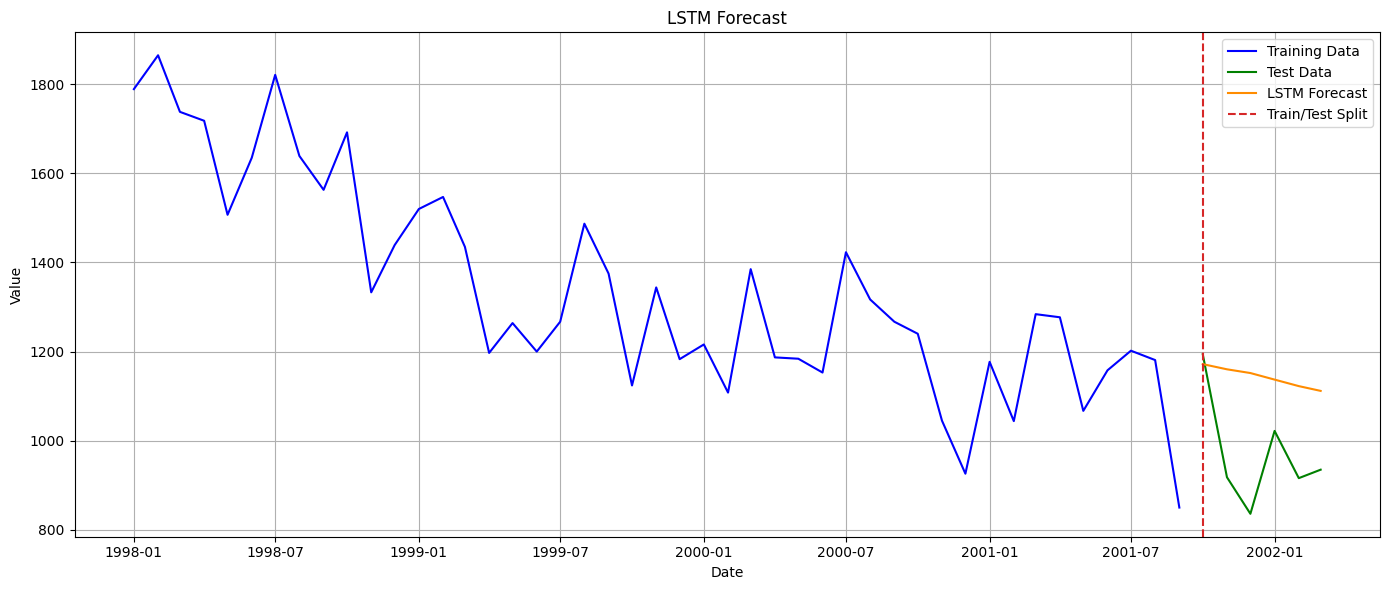

MAE: 179.78
MAPE: 19.79%
RMSE: 202.53

Rolling-origin cross-validation:


In [17]:
datasets = [
    wti_oil_df,
    saugeen_river_df,
    egg_sales_df,
    australian_electricity_demand_df,
    car_parts_df
]

dataset_names = [
    "WTI Oil",
    "Saugeen River",
    "Egg Sales",
    "Australian Electricity Demand",
    "Car Parts"
]

results = {}

for name, df in zip(dataset_names, datasets):
    train_df, test_df = split_train_test(df, test_size=0.1)
    print(f"==== {name} ====")
    res = lstm_forecast(train_df, test_df, crossval=True, cv_splits=3, cv_test_size=0.1)
    results[name] = res



----------------------------------------------------------------------------------------------------------------